# EE 519 — Time-domain Analysis of speech (Notebook 3)
## Short-Time Autocorrelation, Pitch Estimation, and Voicing Cues

### Goals
By the end of this notebook, you will be able to:
1. Compute **short-time autocorrelation** for speech frames.
2. Visually compare autocorrelation for **silence**, **voiced**, and **unvoiced** frames.
3. Use autocorrelation peak picking to estimate **pitch (F0)**.
4. Compute an **ACF peak strength** measure as a voicing cue.
5. Understand common pitfalls (octave errors, noise, weak voicing) and simple fixes.

### Inputs
- A speech WAV file (recommended: same as Notebook 2)

> In Notebook 4 we’ll combine energy + ZCR + ACF peak strength for V/UV/S classification.


---
## 0) Setup
We re-use framing utilities and implement autocorrelation + pitch functions.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio, display

plt.rcParams["figure.figsize"] = (12, 3)
plt.rcParams["axes.grid"] = True

def to_mono(x):
    x = np.asarray(x)
    if x.ndim == 2:
        x = x.mean(axis=1)
    if np.issubdtype(x.dtype, np.integer):
        maxv = np.iinfo(x.dtype).max
        x = x.astype(np.float32) / maxv
    else:
        x = x.astype(np.float32)
    return np.clip(x, -1.0, 1.0)

def remove_dc(x):
    return x - np.mean(x)

def play_audio(x, fs):
    display(Audio(x, rate=fs))

def plot_waveform(x, fs, title="Waveform", tlim=None):
    t = np.arange(len(x)) / fs
    plt.figure()
    plt.plot(t, x, linewidth=0.8)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(title)
    if tlim is not None:
        plt.xlim(tlim)
    plt.show()

def frame_signal(x, N, H):
    L = len(x)
    if L < N:
        return np.zeros((0, N), dtype=np.float32)
    M = 1 + (L - N) // H
    frames = np.zeros((M, N), dtype=np.float32)
    for m in range(M):
        start = m * H
        frames[m] = x[start:start+N]
    return frames

def hamming_window(N):
    return np.hamming(N).astype(np.float32)

def frame_times(M, N, H, fs):
    return (np.arange(M)*H + N/2) / fs

---
## 1) Load a speech signal
Use the same WAV as earlier notebooks.


Loaded: speech.wav
Sampling rate (Hz): 16000
Duration (s): 3.0


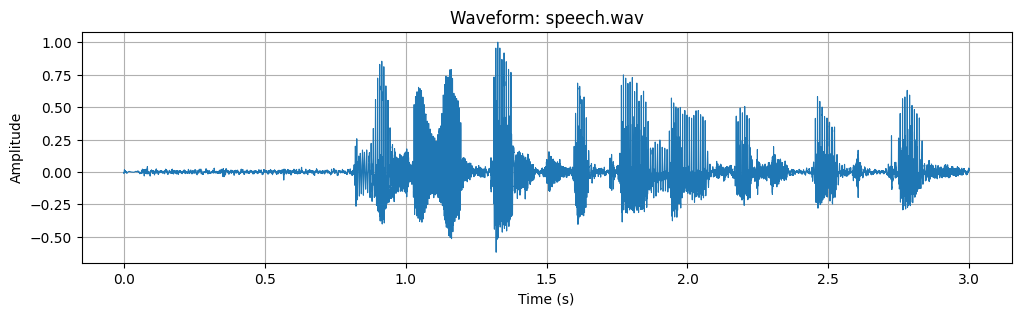

In [2]:
wav_path = "speech.wav"  # <- change as needed

if not os.path.exists(wav_path):
    print(f"File not found: {wav_path}\nUpload a WAV and update wav_path.")
else:
    fs, x = wavfile.read(wav_path)
    x = to_mono(x)
    print("Loaded:", wav_path)
    print("Sampling rate (Hz):", fs)
    print("Duration (s):", len(x)/fs)
    play_audio(x, fs)
    plot_waveform(x, fs, title=f"Waveform: {wav_path}")

---
## 2) Framing + windowing
We will use typical values and a Hamming window.

- frame length: 25 ms
- hop: 10 ms
- window: Hamming

We also remove DC offset per frame before autocorrelation (recommended).


In [3]:
frame_ms = 25.0
hop_ms = 10.0

if "x" in globals():
    N = int(round(frame_ms * 1e-3 * fs))
    H = int(round(hop_ms   * 1e-3 * fs))
    w = hamming_window(N)
    frames = frame_signal(x, N, H)
    t_frames = frame_times(frames.shape[0], N, H, fs)
    print(f"N={N} samples ({frame_ms} ms), H={H} samples ({hop_ms} ms)")
    print("Frames shape:", frames.shape)

N=400 samples (25.0 ms), H=160 samples (10.0 ms)
Frames shape: (298, 400)


---
## 3) Autocorrelation (ACF): definition + intuition

### Definition (short-time autocorrelation)
For a windowed frame \(x_m[n] = x[n+mH] w[n]\), the autocorrelation at lag \(k\) is:
\[
R_m[k] = \sum_{n=0}^{N-1-k} x_m[n] \, x_m[n+k]
\]

### Intuition
- \(R_m[0]\) is maximum and relates to energy.
- For **voiced** frames, ACF shows a clear peak at the pitch period lag.
- For **unvoiced** frames, ACF decays quickly and has no stable periodic peak.


In [4]:
def autocorr_frame(frame, max_lag=None, use_window=True, remove_mean=True):
    """Compute autocorrelation R[k] for k=0..max_lag (inclusive)."""
    x = frame.astype(np.float32).copy()
    if remove_mean:
        x = x - np.mean(x)
    if use_window:
        # if the caller passes already-windowed frame, set use_window=False
        pass
    if max_lag is None or max_lag >= len(x):
        max_lag = len(x) - 1
    R = np.zeros(max_lag + 1, dtype=np.float32)
    for k in range(max_lag + 1):
        R[k] = np.dot(x[:len(x)-k], x[k:])
    return R

def normalize_acf(R):
    return R / (R[0] + 1e-12)

---
## 4) Pick three representative frames: silence / voiced / unvoiced
You can do this by choosing approximate times.

### Step 1: choose three time stamps
- one in **silence**
- one in a **voiced vowel**
- one in an **unvoiced fricative**

We’ll map time → nearest frame index.


In [12]:
# Edit these times after inspecting your waveform (seconds)
t_sil   = 0.2
t_voiced= 1.32
t_unv   = 1.42

def time_to_frame_index(t, fs, N, H):
    # approximate mapping using frame center time
    return int(round((t*fs - N/2) / H))

if "frames" in globals():
    m_sil = np.clip(time_to_frame_index(t_sil, fs, N, H), 0, len(frames)-1)
    m_v   = np.clip(time_to_frame_index(t_voiced, fs, N, H), 0, len(frames)-1)
    m_u   = np.clip(time_to_frame_index(t_unv, fs, N, H), 0, len(frames)-1)

    print("Frame indices:")
    print("silence:", m_sil, "| center time ~", t_frames[m_sil])
    print("voiced :", m_v,   "| center time ~", t_frames[m_v])
    print("unvoiced:", m_u,  "| center time ~", t_frames[m_u])

Frame indices:
silence: 19 | center time ~ 0.2025
voiced : 131 | center time ~ 1.3225
unvoiced: 141 | center time ~ 1.4225


### Step 2: visualize the chosen frames


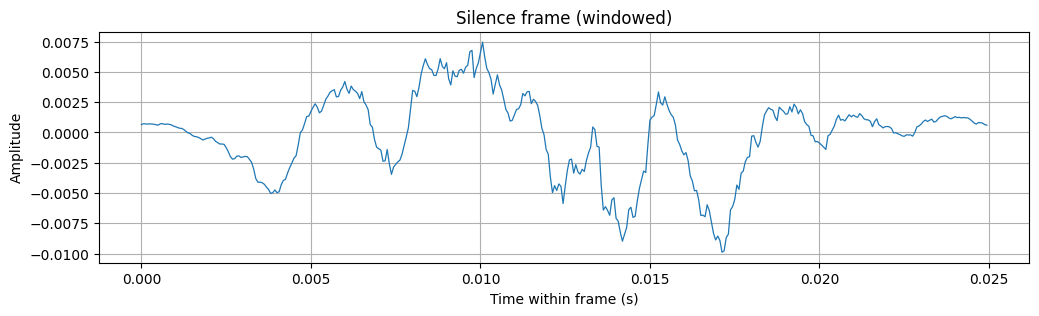

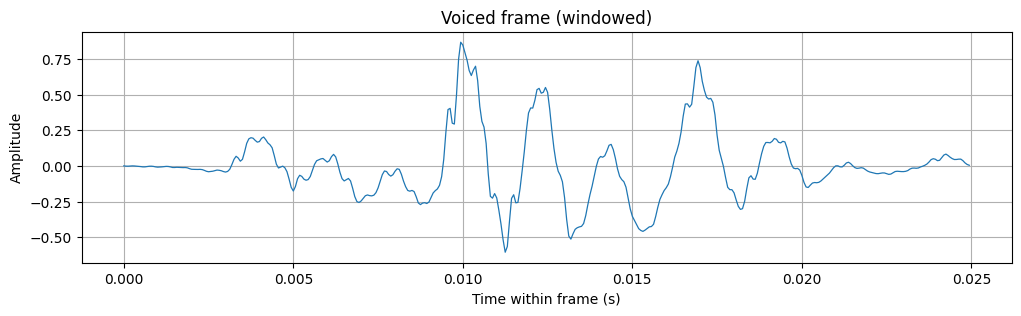

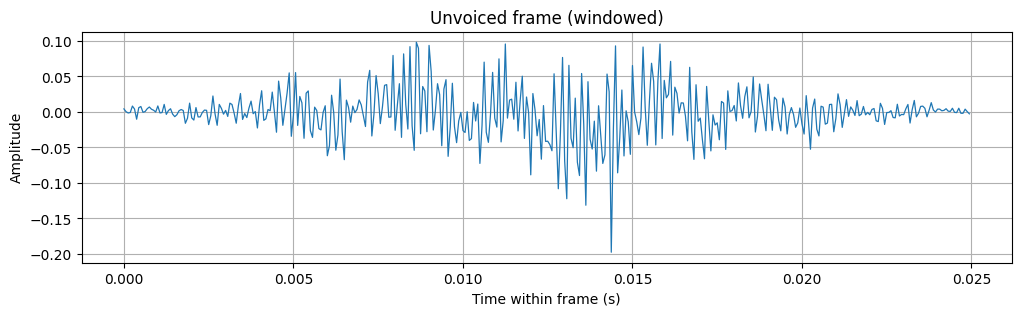

In [13]:
def plot_frame(frame, fs, title="frame"):
    t = np.arange(len(frame)) / fs
    plt.figure(figsize=(12, 3))
    plt.plot(t, frame, linewidth=0.9)
    plt.xlabel("Time within frame (s)")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.show()

if "frames" in globals():
    f_sil = frames[m_sil] * w
    f_v   = frames[m_v]   * w
    f_u   = frames[m_u]   * w

    plot_frame(f_sil, fs, "Silence frame (windowed)")
    plot_frame(f_v, fs,   "Voiced frame (windowed)")
    plot_frame(f_u, fs,   "Unvoiced frame (windowed)")

---
## 5) Autocorrelation plots: silence vs voiced vs unvoiced
We’ll compute and plot normalized ACF for the three frames.

Key expectation:
- Voiced: prominent peak at nonzero lag (pitch period)
- Unvoiced: no clear periodic peak
- Silence: very low-energy; ACF mostly near zero after normalization may be unstable


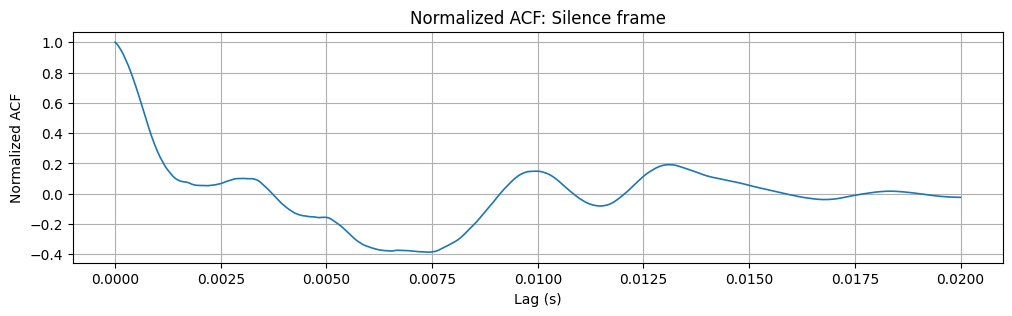

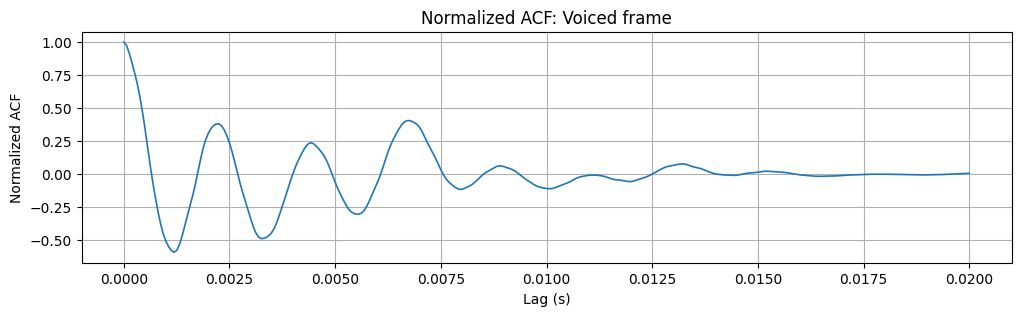

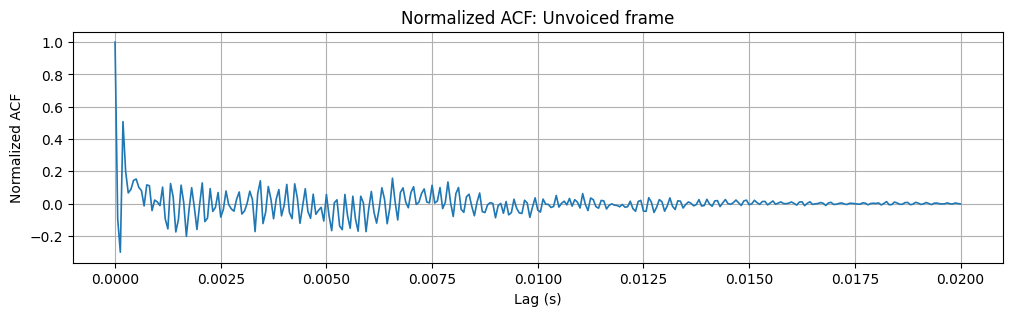

In [14]:
def plot_acf(R, fs, title="ACF", max_hz=None):
    k = np.arange(len(R))
    lag_s = k / fs
    plt.figure(figsize=(12, 3))
    plt.plot(lag_s, R, linewidth=1.2)
    plt.xlabel("Lag (s)")
    plt.ylabel("Normalized ACF") 
    plt.title(title)
    if max_hz is not None:
        min_lag = 1/max_hz
        plt.xlim(0, max(0.02, 5*min_lag))
    plt.show()

if "frames" in globals():
    max_lag = int(0.02 * fs)  # up to 20 ms lag (sufficient for typical pitch periods)
    R_sil = normalize_acf(autocorr_frame(f_sil, max_lag=max_lag, remove_mean=True))
    R_v   = normalize_acf(autocorr_frame(f_v,   max_lag=max_lag, remove_mean=True))
    R_u   = normalize_acf(autocorr_frame(f_u,   max_lag=max_lag, remove_mean=True))

    plot_acf(R_sil, fs, "Normalized ACF: Silence frame")
    plot_acf(R_v,   fs, "Normalized ACF: Voiced frame")
    plot_acf(R_u,   fs, "Normalized ACF: Unvoiced frame")

---
## 6) ACF peak and pitch: basic idea

For voiced speech:
- Let \(k^*\) be the lag (in samples) of the first strong peak (excluding k=0).
- Then
\[
F_0 \approx \frac{F_s}{k^*}
\]

### Pitch search range
Human pitch (rough guideline):
- \(F_0\) between 60–400 Hz (can adjust)

Convert to lag range:
\[
k \in \left[\frac{F_s}{F_{max}}, \frac{F_s}{F_{min}}\right]
\]


Voiced frame pitch estimate: F0≈148.15 Hz (k*=108 samples, peak=0.406)


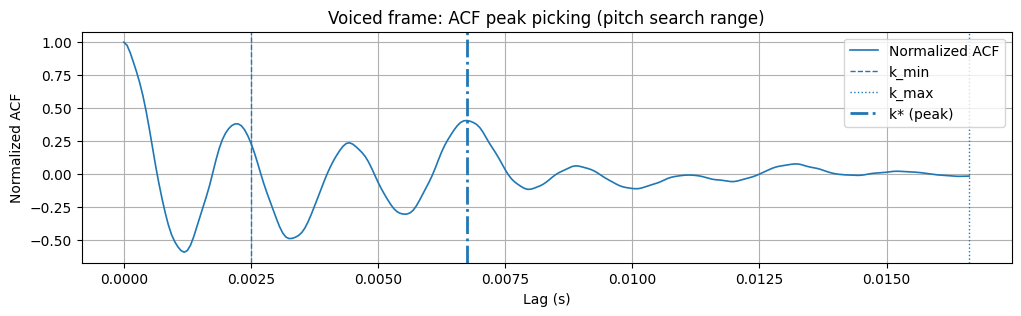

In [15]:
def acf_pitch_from_frame(frame_windowed, fs, fmin=60, fmax=400):
    """Estimate pitch from one windowed frame using normalized ACF peak picking."""
    # Compute ACF up to max lag of interest
    k_min = int(fs / fmax)
    k_max = int(fs / fmin)
    k_max = min(k_max, len(frame_windowed) - 1)

    R = autocorr_frame(frame_windowed, max_lag=k_max, remove_mean=True)
    Rn = normalize_acf(R)

    # Search for best peak in [k_min, k_max]
    search = Rn[k_min:k_max+1]
    k_rel = np.argmax(search)
    k_star = k_min + k_rel
    peak_val = float(Rn[k_star])

    f0 = fs / k_star if k_star > 0 else 0.0
    return float(f0), int(k_star), peak_val, Rn, (k_min, k_max)

if "frames" in globals():
    f0_v, k_v, p_v, Rn_v, (kmin, kmax) = acf_pitch_from_frame(f_v, fs)
    print(f"Voiced frame pitch estimate: F0≈{f0_v:.2f} Hz (k*={k_v} samples, peak={p_v:.3f})")

    # Plot ACF with search range marked
    lag = np.arange(len(Rn_v)) / fs
    plt.figure(figsize=(12, 3))
    plt.plot(lag, Rn_v, linewidth=1.2, label="Normalized ACF")
    plt.axvline(kmin/fs, linestyle="--", linewidth=1, label="k_min")
    plt.axvline(kmax/fs, linestyle=":", linewidth=1, label="k_max")
    plt.axvline(k_v/fs,  linestyle="-.", linewidth=2, label="k* (peak)")
    plt.title("Voiced frame: ACF peak picking (pitch search range)")
    plt.xlabel("Lag (s)")
    plt.ylabel("Normalized ACF")
    plt.legend()
    plt.show()

---
## 7) Frame-wise pitch tracking
We estimate pitch for every frame, but only trust it when the ACF peak is strong.

We’ll compute:
- \(F_0[m]\) per frame
- peak strength \(P[m]\) per frame

Then we’ll plot a pitch track over time.


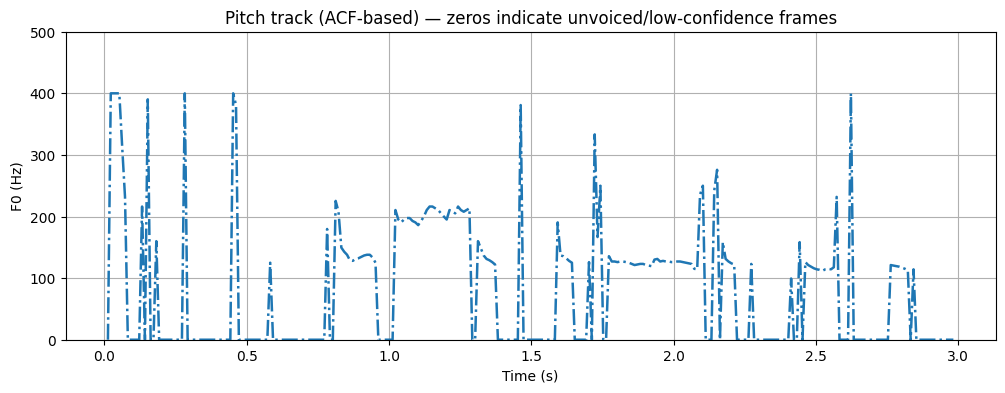

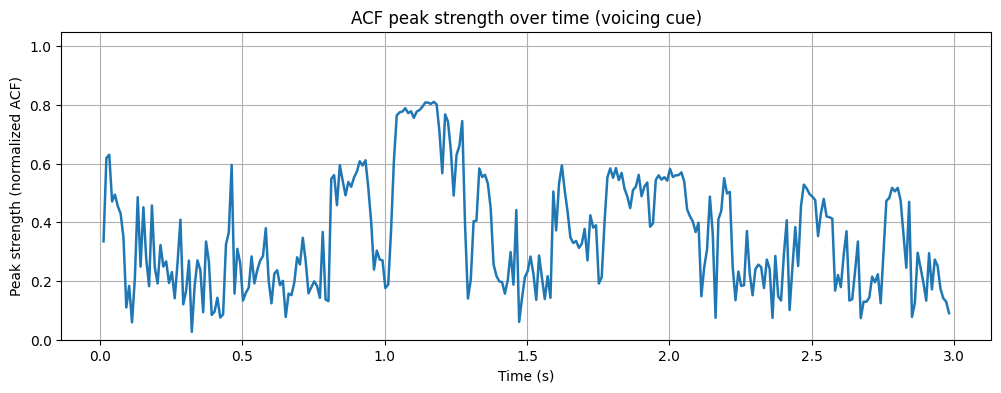

In [25]:
def pitch_track_acf(frames, w, fs, fmin=60, fmax=400, peak_thresh=0.35):
    M, N = frames.shape
    f0 = np.zeros(M, dtype=np.float32)
    peak = np.zeros(M, dtype=np.float32)
    kmin = int(fs / fmax)
    kmax = int(fs / fmin)
    kmax = min(kmax, N-1)

    for m in range(M):
        fw = (frames[m] * w).astype(np.float32)
        # ACF up to kmax
        R = autocorr_frame(fw, max_lag=kmax, remove_mean=True)
        Rn = normalize_acf(R)
        search = Rn[kmin:kmax+1]
        k_star = kmin + int(np.argmax(search))
        peak[m] = Rn[k_star]
        if peak[m] >= peak_thresh:
            f0[m] = fs / k_star
        else:
            f0[m] = 0.0
    return f0, peak, (kmin, kmax)

if "frames" in globals():
    F0, P, (kmin, kmax) = pitch_track_acf(frames, w, fs, peak_thresh=0.35)

    plt.figure(figsize=(12, 4))
    plt.plot(t_frames, F0, linewidth=1.8, linestyle="-.")
    plt.title("Pitch track (ACF-based) — zeros indicate unvoiced/low-confidence frames") 
    plt.xlabel("Time (s)")
    plt.ylabel("F0 (Hz)")
    plt.ylim(0, 500)
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.plot(t_frames, P, linewidth=1.8)
    plt.title("ACF peak strength over time (voicing cue)")
    plt.xlabel("Time (s)")
    plt.ylabel("Peak strength (normalized ACF)")
    plt.ylim(0, 1.05)
    plt.show()

---
## 8) Voiced vs unvoiced vs silence via ACF peak strength
ACF peak strength is often:
- high for voiced
- low for unvoiced
- unstable/low for silence (depends on noise)

Let’s compute statistics in three regions.


In [26]:
regions = [
    ("Silence", 0, 0.8),
    ("Voiced vowel", 1.32, 1.38),
    ("Unvoiced fricative", 1.4, 1.46),
]

def region_stats(feature_t, feature, regions):
    for label, t0, t1 in regions:
        idx = np.where((feature_t >= t0) & (feature_t <= t1))[0]
        if len(idx) == 0:
            print(label, "-> no frames in region; adjust times") 
            continue
        vals = feature[idx]
        print(f"{label}: mean={np.mean(vals):.3f} | std={np.std(vals):.3f} | min={np.min(vals):.3f} | max={np.max(vals):.3f}")

if "frames" in globals():
    print("ACF peak strength stats:")
    region_stats(t_frames, P, regions)

    print("\nPitch stats (nonzero only):")
    for label, t0, t1 in regions:
        idx = np.where((t_frames >= t0) & (t_frames <= t1) & (F0 > 0))[0]
        if len(idx) == 0:
            print(label, "-> no voiced frames (or threshold too high)") 
            continue
        vals = F0[idx]
        print(f"{label}: mean={np.mean(vals):.1f} Hz | std={np.std(vals):.1f} Hz")

ACF peak strength stats:
Silence: mean=0.251 | std=0.129 | min=0.027 | max=0.631
Voiced vowel: mean=0.515 | std=0.065 | min=0.406 | max=0.584
Unvoiced fricative: mean=0.207 | std=0.044 | min=0.157 | max=0.299

Pitch stats (nonzero only):
Silence: mean=314.1 Hz | std=103.0 Hz
Voiced vowel: mean=132.2 Hz | std=8.4 Hz
Unvoiced fricative -> no voiced frames (or threshold too high)


---
## 9) Common problems + simple fixes

### Problem 1: octave errors
- The strongest peak might occur at 2× the true period.
- A simple fix is to choose the **first strong peak** rather than the global maximum.

### Problem 2: weak voicing or noise
- Peak strength threshold may be too strict or too lenient.
- Try adjusting `peak_thresh`.

### Problem 3: jittery pitch track
- Apply a simple median filter to smooth.


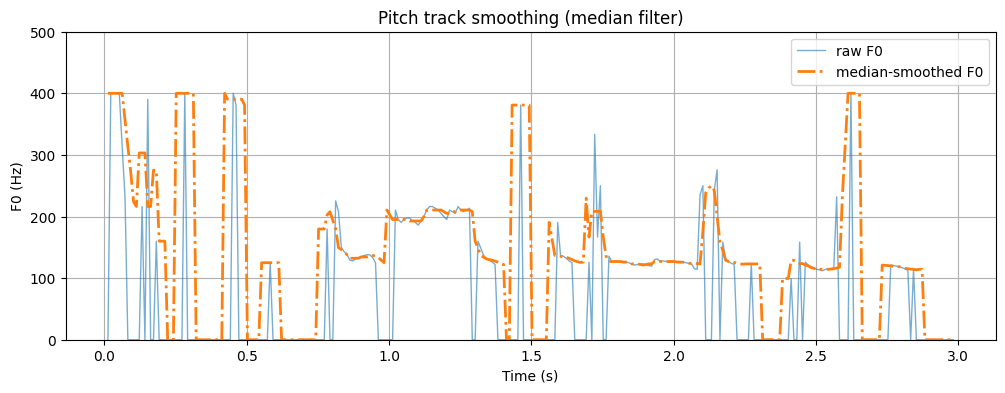

In [28]:
# Simple median smoothing for pitch (only nonzero values kept)
def median_smooth_pitch(f0, k=5):
    f0_sm = f0.copy()
    half = k//2
    for i in range(len(f0)):
        a = max(0, i-half)
        b = min(len(f0), i+half+1)
        window = f0[a:b]
        window = window[window > 0]
        if len(window) > 0:
            f0_sm[i] = np.median(window)
        else:
            f0_sm[i] = 0.0
    return f0_sm

if "frames" in globals():
    F0_sm = median_smooth_pitch(F0, k=7)
    plt.figure(figsize=(12, 4))
    plt.plot(t_frames, F0, linewidth=1.0, alpha=0.6, label="raw F0")
    plt.plot(t_frames, F0_sm, linewidth=2.0, label="median-smoothed F0",linestyle="-.")
    plt.title("Pitch track smoothing (median filter)")
    plt.xlabel("Time (s)")
    plt.ylabel("F0 (Hz)")
    plt.ylim(0, 500)
    plt.legend()
    plt.show()

---
## 10) Summary + what’s next

✅ You implemented and interpreted:
- short-time autocorrelation
- ACF peak strength as a voicing cue
- pitch estimation via ACF peak picking

➡️ Next: **Notebook 4 — Applications** (Could be Assignment)
- speech vs silence detection (energy thresholding)
- voiced/unvoiced/silence using energy + ZCR + ACF peak strength
- visualization of decisions aligned to waveform

### Quick check (answer in a markdown cell)
1. Why do we restrict peak search to a lag range for pitch?
2. What does the ACF peak strength measure (in words)?
3. What is one reason pitch estimation can produce octave errors?
